# Overview
In this notebook, a dataset containing clinical records of heart failure and death events was analyzed. The original dataset was downloaded from Kaggle. Different clinical measurements were presented in the dataset. Exploratory data analysis among different variables was performed and a predictive model for identifying potential death events was built. The dataset and some great notebooks can be found [here](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data).

## 1. Data Processing

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [5]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
#no missing  values
data.isnull().mean()

age                         0.0
anaemia                     0.0
creatinine_phosphokinase    0.0
diabetes                    0.0
ejection_fraction           0.0
high_blood_pressure         0.0
platelets                   0.0
serum_creatinine            0.0
serum_sodium                0.0
sex                         0.0
smoking                     0.0
time                        0.0
DEATH_EVENT                 0.0
dtype: float64

Note: gender: 1 for Male, 0 for Female

## 2. EDA
Some factors to be considered:
- Distribution of death events in the dataset: balanced or not?
- Distribution of age among classes
- Distribution of high blood pressure among classes
- Distribution of diabetes among classes
- Pair scatterplots and correlations among numeric variables


<AxesSubplot:ylabel='DEATH_EVENT'>

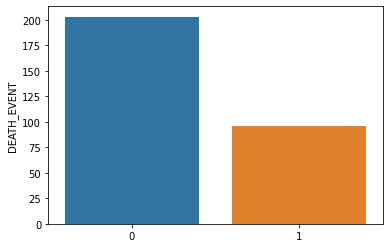

In [8]:
#distribution of classes: twice as many class 0 as class 1
sns.barplot(data["DEATH_EVENT"].value_counts().index,data["DEATH_EVENT"].value_counts())

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='age'>

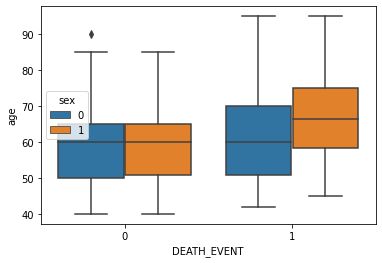

In [9]:
#distribution of age and gender among classes
sns.boxplot("DEATH_EVENT","age",data=data,hue="sex")

On average, people with death events have higher ages than people without death events based on the above boxplot. This difference is more significant among males. Male within class 1 has a much higher median age than female within class 1, also has a much higher age than male within class 0.

In [11]:
pd.crosstab(data["high_blood_pressure"],data["DEATH_EVENT"])

DEATH_EVENT,0,1
high_blood_pressure,,
0,137,57
1,66,39


The ratio row-wise indicates that people with high blood pressure has a high chance of having death events.

In [12]:
pd.crosstab(data["diabetes"],data["DEATH_EVENT"])

DEATH_EVENT,0,1
diabetes,,
0,118,56
1,85,40


Similarly, the ratio row-wise indicates that people with diabetes has a high chance of having death events.

In [22]:
num_cols = data[['creatinine_phosphokinase', 
       'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium']]

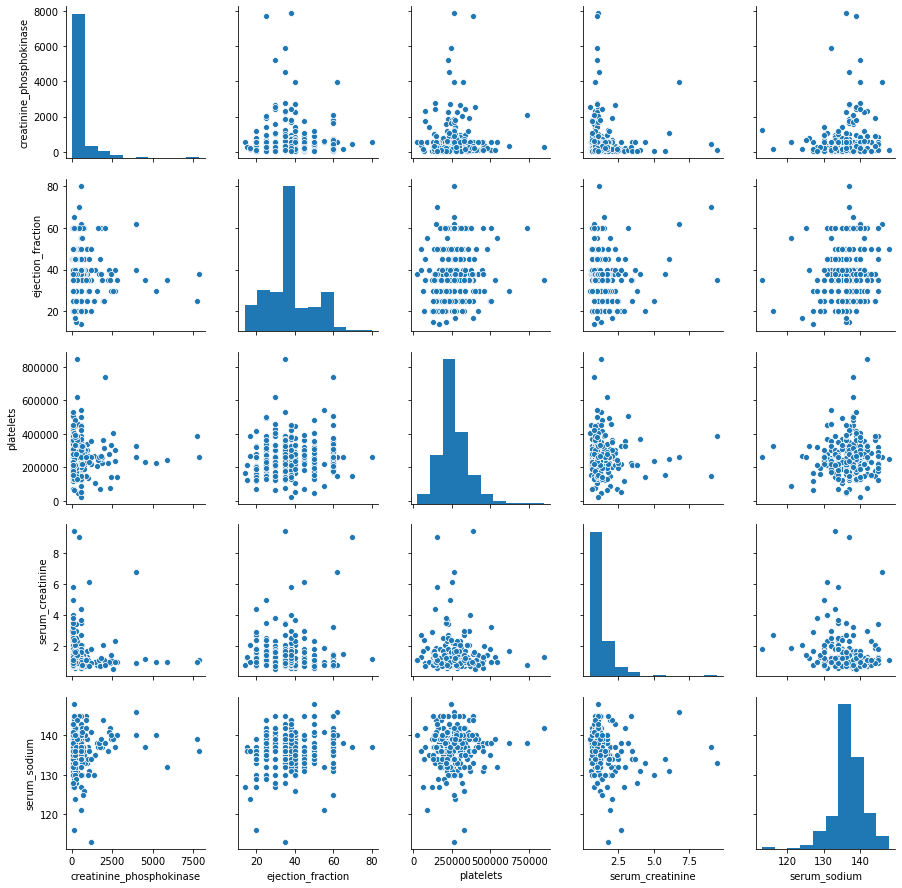

In [23]:
sns.pairplot(num_cols)

In [24]:
num_cols.corr()

,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
creatinine_phosphokinase,1.000000,-0.044080,0.024463,-0.016408,0.059550
ejection_fraction,-0.044080,1.000000,0.072177,-0.011302,0.175902
platelets,0.024463,0.072177,1.000000,-0.041198,0.062125
serum_creatinine,-0.016408,-0.011302,-0.041198,1.000000,-0.189095
serum_sodium,0.059550,0.175902,0.062125,-0.189095,1.000000


Correlation coefficients are not very high, so we can include all of them in our later modeling.

## 3. Modeling

In [25]:
data.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [26]:
X = data[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]
y = data["DEATH_EVENT"]

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
#stratify due to imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

Below code chunk is from this [great notebook](https://www.kaggle.com/alanabraham/heart-failure-quick-prediction-93-rate?scriptVersionId=41220672)

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.01, n_estimators=1000, objective='binary:logistic')

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, 
                    cv=skf.split(X_train,y_train), verbose=0 )

grid.fit(X_train,y_train,early_stopping_rounds=20,eval_set=[(X_test, y_test)])

p2x = grid.best_estimator_.predict(X_test)
s2x=accuracy_score(y_test,p2x)

[0]	validation_0-error:0.21667
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.23333
[2]	validation_0-error:0.25000
[3]	validation_0-error:0.23333
[4]	validation_0-error:0.23333
[5]	validation_0-error:0.25000
[6]	validation_0-error:0.26667
[7]	validation_0-error:0.25000
[8]	validation_0-error:0.23333
[9]	validation_0-error:0.23333
[10]	validation_0-error:0.21667
[11]	validation_0-error:0.21667
[12]	validation_0-error:0.23333
[13]	validation_0-error:0.21667
[14]	validation_0-error:0.21667
[15]	validation_0-error:0.23333
[16]	validation_0-error:0.21667
[17]	validation_0-error:0.21667
[18]	validation_0-error:0.21667
[19]	validation_0-error:0.20000
[20]	validation_0-error:0.21667
[21]	validation_0-error:0.20000
[22]	validation_0-error:0.21667
[23]	validation_0-error:0.20000
[24]	validation_0-error:0.21667
[25]	validation_0-error:0.20000
[26]	validation_0-error:0.20000
[27]	validation_0-error:0.20000
[28]	validation_0-error:0.20000
[29]	validation_

In [67]:
print("Extra Gradient Booster Classifier Accuracy :", "{:.2f}%".format(100*s2x))

Extra Gradient Booster Classifier Success Rate : 80.00%


<AxesSubplot:>

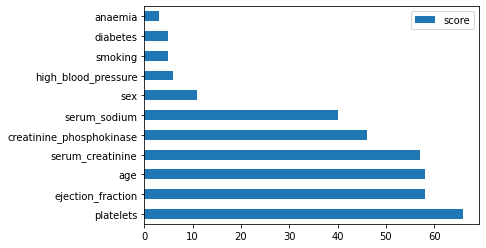

In [70]:
feature_important = grid.best_estimator_.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

Stratifies train test split has a lower accuracy than the usual train test split, but XBG generally performs the best. Based on the above feature importance plot, platelets, ejection fraction and age are top three factors influencing the outcome DEATH_EVENT most.